# Primary sector - Hand in

### This notebook will give an overview on the datasets and algorithms that will be used for the first hand-in regarding the primary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import ipyparallel as ipp
import os
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from scipy.stats import boxcox
import warnings
from pmdarima import auto_arima

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

from platform import python_version
if python_version() < '3.8':
    import pickle5 as pickle
else:
    import pickle

In [2]:
def drop_correlated_features(df, thr=0.8):
    """
    Function to detect all correlated features
    :param df: general dataframe and threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

## 1. Import data and check for stationarity

In [3]:
path = '../../src/data/Abgabe_1'

In [5]:
#import data
df_turbine = pd.read_csv(os.path.join(path, 'Turbine_Data.csv')).rename(columns={'Unnamed: 0':'timestamp'}).dropna(subset=['WindSpeed'])
df_turbine

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
144,2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.000000,-9.960830,NaN,NaN,G01,8.000000,2.279088
145,2018-01-01 00:10:00+00:00,-5.822360,23.039754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,300.428571,-9.628441,NaN,NaN,G01,300.428571,2.339343
146,2018-01-01 00:20:00+00:00,-5.279409,22.948703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,340.000000,-9.491235,NaN,NaN,G01,340.000000,2.455610
147,2018-01-01 00:30:00+00:00,-4.648054,22.966851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,345.000000,-9.856136,NaN,NaN,G01,345.000000,2.026754
148,2018-01-01 00:40:00+00:00,-4.684632,22.936520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,345.000000,-9.745593,NaN,NaN,G01,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,...,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,G01,178.000000,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,...,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,G01,178.000000,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,...,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,G01,178.000000,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,...,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,G01,190.000000,3.284468


### For a possible comparison to a feature based regression model, we will have a look at NaN values and correlated features.

In [77]:
# we clearly see that we have a lot of NaN values inside our dataframe
df_turbine.isna().sum()

timestamp                           0
ActivePower                       159
AmbientTemperatue                1318
BearingShaftTemperature         32747
Blade1PitchAngle                52609
Blade2PitchAngle                52749
Blade3PitchAngle                52749
ControlBoxTemperature           33102
GearboxBearingTemperature       32731
GearboxOilTemperature           32703
GeneratorRPM                    32851
GeneratorWinding1Temperature    32712
GeneratorWinding2Temperature    32705
HubTemperature                  32861
MainBoxTemperature              32757
NacellePosition                 22426
ReactivePower                     139
RotorRPM                        33007
TurbineStatus                   32110
WTG                                 0
WindDirection                   22426
WindSpeed                           0
dtype: int64

In [78]:
# Fill numeric rows with the median
for label, content in df_turbine.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing numeric values with median since it's more robust than the mean
            df_turbine[label] = content.fillna(content.median())

In [79]:
df_turbine

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
144,2018-01-01 00:00:00+00:00,-5.357727,23.148729,42.907807,0.393893,0.884870,0.884870,0.0,64.823010,57.176508,...,64.917309,37.003815,39.512476,8.000000,-9.960830,10.079097,2.0,G01,8.000000,2.279088
145,2018-01-01 00:10:00+00:00,-5.822360,23.039754,42.907807,0.393893,0.884870,0.884870,0.0,64.823010,57.176508,...,64.917309,37.003815,39.512476,300.428571,-9.628441,10.079097,2.0,G01,300.428571,2.339343
146,2018-01-01 00:20:00+00:00,-5.279409,22.948703,42.907807,0.393893,0.884870,0.884870,0.0,64.823010,57.176508,...,64.917309,37.003815,39.512476,340.000000,-9.491235,10.079097,2.0,G01,340.000000,2.455610
147,2018-01-01 00:30:00+00:00,-4.648054,22.966851,42.907807,0.393893,0.884870,0.884870,0.0,64.823010,57.176508,...,64.917309,37.003815,39.512476,345.000000,-9.856136,10.079097,2.0,G01,345.000000,2.026754
148,2018-01-01 00:40:00+00:00,-4.684632,22.936520,42.907807,0.393893,0.884870,0.884870,0.0,64.823010,57.176508,...,64.917309,37.003815,39.512476,345.000000,-9.745593,10.079097,2.0,G01,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,...,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,G01,178.000000,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,...,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,G01,178.000000,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,...,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,G01,178.000000,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,...,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,G01,190.000000,3.284468


In [80]:
# look at distribution
df_turbine.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.0,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,94595.000000,9.459500e+04,94595.000000,94595.000000
mean,615.391435,28.777706,43.028144,4.546074,4.932412,4.932412,0.0,64.506008,57.414434,1107.150993,70.007739,69.323963,36.988784,39.596756,192.884959,88.303816,9.951032,1.517125e+03,192.884959,5.878960
std,608.745069,4.342252,4.179528,14.519489,14.233803,14.233803,0.0,8.095315,5.121435,426.409308,18.492535,18.521654,3.935758,4.394800,77.348806,116.588013,3.805217,2.924388e+05,77.348806,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.285279,25.675923,41.294783,0.393893,0.884870,0.884870,0.0,61.974185,55.807282,1033.217395,60.715813,59.936847,35.506499,37.958911,161.500000,-0.426715,9.270398,2.000000e+00,161.500000,3.823330
50%,400.051199,28.350483,42.907807,0.393893,0.884870,0.884870,0.0,64.823010,57.176508,1122.267037,65.695628,64.917309,37.003815,39.512476,182.000000,36.360616,10.079097,2.000000e+00,182.000000,5.557765
75%,1061.766135,31.622619,44.619445,0.393893,0.884870,0.884870,0.0,67.282982,58.613880,1281.973675,71.978778,71.282192,38.629170,41.132087,229.500000,147.555526,11.496425,2.000000e+00,229.500000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


C:\Users\Nikla\AppData\Local\Temp/ipykernel_26172/3493654454.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


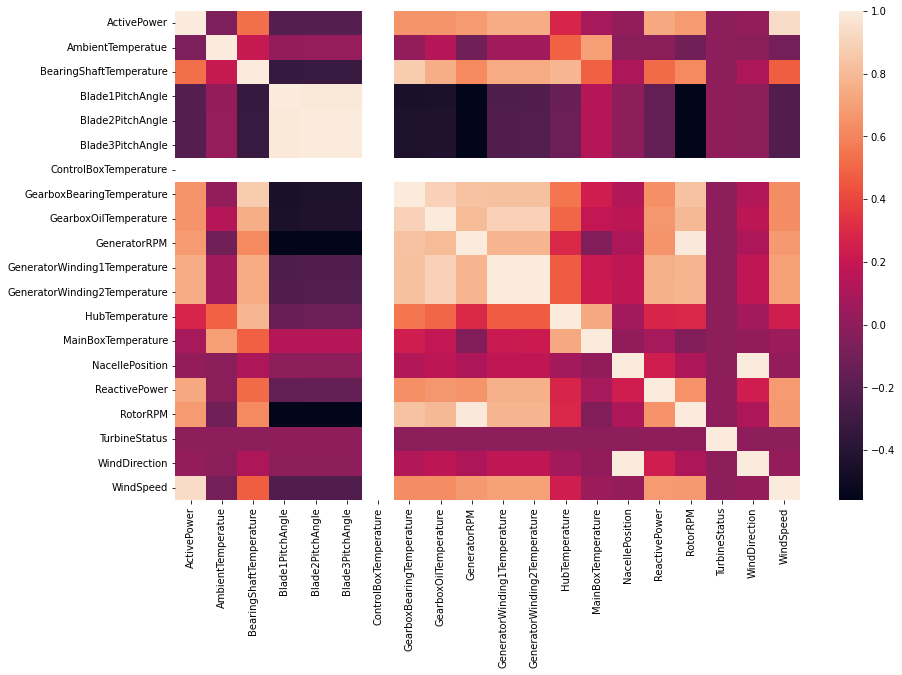

In [81]:
# investigate correlation heatmap
corrMatrix=df_turbine.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [82]:
#drop WTG feature since it is always the same value and windSpeed as target
df_target = df_turbine['WindSpeed']
#drop WTG and ControlBoxTemperature as they have always the same value in the whole column
df_turbine_cor = df_turbine.drop(columns=['WTG','WindSpeed','ControlBoxTemperature'])
# drop highly correlated features for a SVM baseline
df_turbine_cor = drop_correlated_features(df_turbine_cor)
# drop Blade3PitchAngle cause it has too much NaNs
df_turbine_cor = df_turbine_cor.drop(columns=['Blade3PitchAngle'])

The following features are correlated: Blade2PitchAngle and Blade1PitchAngle. Correlation = 0.99
The following features are correlated: Blade3PitchAngle and Blade1PitchAngle. Correlation = 0.99
The following features are correlated: Blade3PitchAngle and Blade2PitchAngle. Correlation = 1.0
The following features are correlated: GearboxBearingTemperature and BearingShaftTemperature. Correlation = 0.87
The following features are correlated: GearboxOilTemperature and GearboxBearingTemperature. Correlation = 0.89
The following features are correlated: GeneratorRPM and GearboxBearingTemperature. Correlation = 0.83
The following features are correlated: GeneratorRPM and GearboxOilTemperature. Correlation = 0.8
The following features are correlated: GeneratorWinding1Temperature and GearboxBearingTemperature. Correlation = 0.83
The following features are correlated: GeneratorWinding1Temperature and GearboxOilTemperature. Correlation = 0.89
The following features are correlated: GeneratorWinding

In [83]:
#attach windspeed again for further processing
df_turbine_cor = pd.concat([df_turbine_cor, df_target], axis = 1)
df_turbine_cor

,timestamp,ActivePower,AmbientTemperatue,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
144,2018-01-01 00:00:00+00:00,-5.357727,23.148729,64.917309,37.003815,39.512476,-9.960830,10.079097,2.0,8.000000,2.279088
145,2018-01-01 00:10:00+00:00,-5.822360,23.039754,64.917309,37.003815,39.512476,-9.628441,10.079097,2.0,300.428571,2.339343
146,2018-01-01 00:20:00+00:00,-5.279409,22.948703,64.917309,37.003815,39.512476,-9.491235,10.079097,2.0,340.000000,2.455610
147,2018-01-01 00:30:00+00:00,-4.648054,22.966851,64.917309,37.003815,39.512476,-9.856136,10.079097,2.0,345.000000,2.026754
148,2018-01-01 00:40:00+00:00,-4.684632,22.936520,64.917309,37.003815,39.512476,-9.745593,10.079097,2.0,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,58.148777,39.008931,36.476562,13.775785,9.234004,2.0,178.000000,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,57.550367,39.006759,36.328125,8.088928,9.229370,2.0,178.000000,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,57.099335,39.003815,36.131944,4.355978,9.236802,2.0,178.000000,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,56.847239,39.003815,36.007805,12.018077,9.237374,2.0,190.000000,3.284468


### We have seen that we have a lot of correlated features. So, we dropped them to be able to use regression baselines like SVM.

In [84]:
df_turbine_cor.isna().sum()

timestamp                       0
ActivePower                     0
AmbientTemperatue               0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

In [86]:
y = df_turbine_cor['WindSpeed'].values
x = df_turbine_cor['timestamp'].values

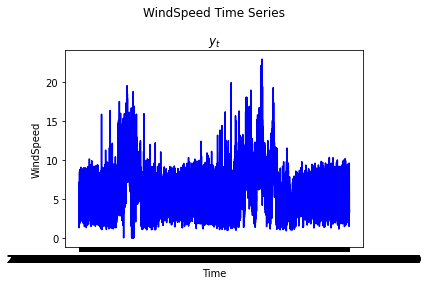

In [87]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

In [98]:
# we select a promising subset out of the data by focusing on newer time intervalls, where data does not have to be imputed via mean 
input_df = df_turbine_cor[df_turbine_cor['timestamp'] > '2019-12-17 00:00:00+00:00']

In [96]:
y = input_df['WindSpeed'].values
x = input_df['timestamp'].values

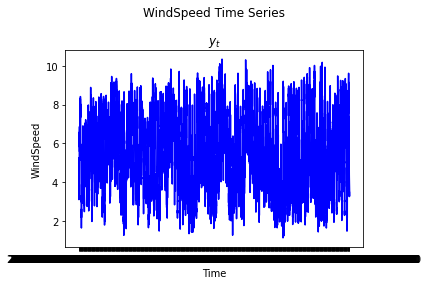

In [97]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

### After searching for a promising subset, we have a look at the newest 15.000 data points.

In [99]:
df_turbine_without_na = input_df

In [100]:
df_turbine_without_na

,timestamp,ActivePower,AmbientTemperatue,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
103105,2019-12-17 00:10:00+00:00,246.703719,21.954866,54.011767,31.001907,32.359375,49.845629,9.232062,2.0,163.00,5.012039
103106,2019-12-17 00:20:00+00:00,235.295899,21.968454,53.747796,31.001907,32.304688,47.636226,9.231939,2.0,163.00,5.015685
103107,2019-12-17 00:30:00+00:00,268.555670,22.023319,53.608796,31.001907,32.237221,54.785349,9.233371,2.0,166.00,5.265058
103108,2019-12-17 00:40:00+00:00,188.746578,22.152230,53.178426,31.001907,32.187500,39.334567,9.230305,2.0,172.00,4.847444
103109,2019-12-17 00:50:00+00:00,86.401582,22.134180,52.162265,31.001907,32.103099,17.690299,9.241146,2.0,166.75,3.956125
...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,58.148777,39.008931,36.476562,13.775785,9.234004,2.0,178.00,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,57.550367,39.006759,36.328125,8.088928,9.229370,2.0,178.00,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,57.099335,39.003815,36.131944,4.355978,9.236802,2.0,178.00,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,56.847239,39.003815,36.007805,12.018077,9.237374,2.0,190.00,3.284468


### We take the first 1150 timestamps for training and  try to predict 50 steps. 

In [103]:
from sklearn.preprocessing import MinMaxScaler
#scale all features without WindSpeed
scale_features =['ActivePower','AmbientTemperatue','GeneratorWinding2Temperature','HubTemperature','MainBoxTemperature','ReactivePower','RotorRPM','TurbineStatus','WindDirection']
scaler = MinMaxScaler()
df_turbine_without_na[scale_features] = scaler.fit_transform(df_turbine_without_na[scale_features])

C:\Users\Nikla\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [107]:
# df_turbine_train = df_turbine_without_na[df_turbine_without_na['timestamp'] < '2020-03-01 00:00:00+00:00']
# df_turbine_test = df_turbine_without_na[df_turbine_without_na['timestamp'] >= '2020-03-01 00:00:00+00:00']

In [158]:
df_turbine_train = df_turbine_without_na [:1150]
df_turbine_test = df_turbine_without_na[1150:1200]

In [159]:
df_turbine_train

,timestamp,ActivePower,AmbientTemperatue,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
103105,2019-12-17 00:10:00+00:00,0.161275,0.138280,0.187906,0.674010,0.184560,0.456858,0.580764,1.520993e-08,0.456583,5.012039
103106,2019-12-17 00:20:00+00:00,0.154825,0.139005,0.184386,0.674010,0.182204,0.452869,0.580756,1.520993e-08,0.456583,5.015685
103107,2019-12-17 00:30:00+00:00,0.173631,0.141931,0.182532,0.674010,0.179298,0.465777,0.580846,1.520993e-08,0.464986,5.265058
103108,2019-12-17 00:40:00+00:00,0.128505,0.148805,0.176792,0.674010,0.177156,0.437880,0.580653,1.520993e-08,0.481793,4.847444
103109,2019-12-17 00:50:00+00:00,0.070636,0.147843,0.163240,0.674010,0.173520,0.398800,0.581335,1.520993e-08,0.467087,3.956125
...,...,...,...,...,...,...,...,...,...,...,...
104266,2019-12-25 01:40:00+00:00,0.233812,0.162708,0.240710,0.652065,0.178583,0.502837,0.603671,1.520993e-08,0.526611,5.769189
104267,2019-12-25 01:50:00+00:00,0.246048,0.163809,0.241236,0.652149,0.179848,0.513252,0.616023,1.520993e-08,0.509804,5.991565
104268,2019-12-25 02:00:00+00:00,0.261438,0.169334,0.242558,0.652178,0.181664,0.522126,0.626599,1.520993e-08,0.526611,5.898572
104269,2019-12-25 02:10:00+00:00,0.254378,0.172376,0.244230,0.652180,0.184524,0.517183,0.623304,1.520993e-08,0.526611,5.665547


In [160]:
df_turbine_test

,timestamp,ActivePower,AmbientTemperatue,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
104271,2019-12-25 02:30:00+00:00,0.312315,0.179582,0.252225,0.652187,0.196491,0.555310,0.662055,1.520993e-08,0.526611,6.300255
104272,2019-12-25 02:40:00+00:00,0.355153,0.187878,0.260584,0.652187,0.205425,0.581211,0.704098,1.520993e-08,0.526611,6.277920
104273,2019-12-25 02:50:00+00:00,0.283308,0.199299,0.263286,0.652187,0.213502,0.541509,0.634634,1.520993e-08,0.505135,6.030460
104274,2019-12-25 03:00:00+00:00,0.379892,0.209025,0.274351,0.652187,0.225020,0.598511,0.698224,1.520993e-08,0.498599,6.274368
104275,2019-12-25 03:10:00+00:00,0.397376,0.216286,0.291795,0.652279,0.236193,0.612641,0.711435,1.520993e-08,0.490196,6.228300
104276,2019-12-25 03:20:00+00:00,0.379841,0.225149,0.296961,0.652289,0.248380,0.594407,0.723731,1.520993e-08,0.492997,6.212405
104277,2019-12-25 03:30:00+00:00,0.408297,0.227835,0.302838,0.652301,0.257022,0.612331,0.721404,1.520993e-08,0.495798,6.317789
104278,2019-12-25 03:40:00+00:00,0.442181,0.234712,0.320392,0.652341,0.265669,0.639006,0.753688,1.520993e-08,0.490196,6.725775
104279,2019-12-25 03:50:00+00:00,0.377357,0.248216,0.325919,0.652279,0.275964,0.596766,0.700963,1.520993e-08,0.490196,5.982323
104280,2019-12-25 04:00:00+00:00,0.465497,0.265655,0.333582,0.657437,0.288215,0.655010,0.775201,1.520993e-08,0.484594,6.507989


In [161]:
#generate split
data_train, target_train, data_test, target_test = df_turbine_train.drop(columns=['WindSpeed','timestamp']),df_turbine_train['WindSpeed'],df_turbine_test.drop(columns=['WindSpeed','timestamp']),df_turbine_test['WindSpeed']

In [162]:
#rmse implementation
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Compute a SVM and a random forest classification baseline for our data points to compare them to the values of ARIMA.

In [163]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(data_train, target_train)
prediction = rf.predict(data_test)
rmse_score = rmse(prediction,target_test) 
print("The RMSE on test set: {:.4f}".format(rmse_score))

The RMSE on test set: 0.1727


In [164]:
from sklearn.svm import SVR

sv_regressor = SVR(kernel = 'rbf')
sv_regressor.fit(data_train, target_train)
prediction = sv_regressor.predict(data_test)
rmse_score = rmse(prediction,target_test) 
print("The RMSE on test set: {:.4f}".format(rmse_score))

The RMSE on test set: 0.1581


### Try to improve by voting ensemble.

In [165]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.svm import SVR

rf = RandomForestRegressor()
sv_regressor = SVR(kernel = 'rbf')

vo_reg = VotingRegressor([('rf', rf), ('svr', sv_regressor)])
vo_reg.fit(data_train, target_train)
prediction = vo_reg.predict(data_test)
rmse_score = rmse(prediction,target_test) 
print("The RMSE on test set: {:.4f}".format(rmse_score))

The RMSE on test set: 0.1654


### Compute a naive baseline for time series data. We use the persistence algorithm. Use the value at the previous time step the predict the expected outcome at the next time step.

In [166]:
# create a lagged representation for the train set to compute a supervised learning problem
values = pd.DataFrame(df_turbine_train['WindSpeed'].values)
df_train= pd.concat([values.shift(1), values], axis=1)
df_train.columns = ['t-1', 't+1']
#drop first row due to NaN
df_train = df_train.iloc[1:]
print(df_train.head(5))

        t-1       t+1
1  5.012039  5.015685
2  5.015685  5.265058
3  5.265058  4.847444
4  4.847444  3.956125
5  3.956125  3.883358


In [167]:
# create a lagged representation for the test set to compute a supervised learning problem
values = pd.DataFrame(df_turbine_test['WindSpeed'].values)
df_test = pd.concat([values.shift(1), values], axis=1)
df_test.columns = ['t-1', 't+1']
#input last value of train t+1 in t-1 test
df_test['t-1'][0] = df_train['t+1'].iloc[-1]
print(df_test.head(5))

        t-1       t+1
0  6.030055  6.300255
1  6.300255  6.277920
2  6.277920  6.030460
3  6.030460  6.274368
4  6.274368  6.228300


In [168]:
#split into input and target
train_X, train_y = df_train.values[:,0], df_train.values[:,1]
test_X, test_y = df_test.values[:,0], df_test.values[:,1]

In [169]:
# persistence model to return actual input
def model_persistence(x):
    return x
#rmse implementation
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [170]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = rmse(predictions,test_y)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.447


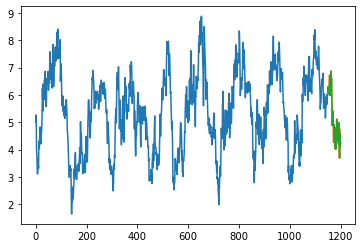

In [171]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

### We can clearly see from our test results that our distribution is already stationary and therefore needs no further preprocessing.

In [172]:
y = df_turbine_without_na['WindSpeed'][:1200].values
x = df_turbine_without_na['timestamp'][:1200].values

C:\Users\Nikla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


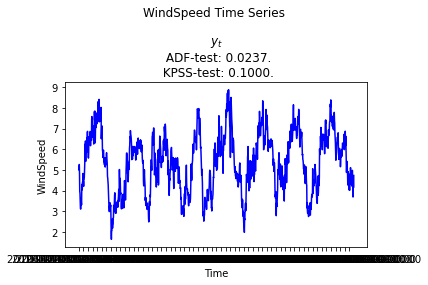

In [173]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
title += '\n ADF-test: {:.4f}.'.format(adfuller(y, regression='ctt')[1])
title += '\n KPSS-test: {:.4f}.'.format(kpss(y, regression='ct', nlags='auto')[1])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

###  ARIMA Selection - Initial Guesses for Autoregressive and Moving Average Order

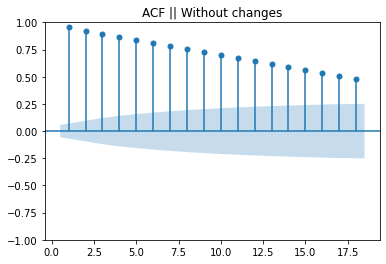

In [178]:
max_lag= 18
title = 'Without changes'
stld_plot = plot_acf(y, lags=range(1, max_lag+1),  title='ACF || '+ title)

C:\Users\Nikla\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


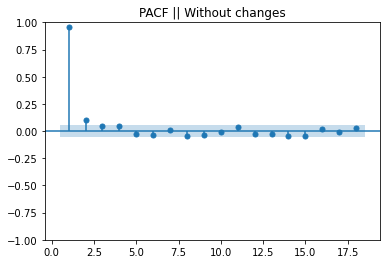

In [179]:
max_lag= 18
title = 'Without changes'
stld_plot = plot_pacf(y, lags=range(1, max_lag+1), title='PACF || ' + title)

### We can see that there is an PACF spike at LAG 1 -> initial guess: ARIMA (1,0,0)

In [181]:
# helper function to evaluate a SARIMA model

def eval_sarima(order, seasonal_order, y, n_train, transform=None, inverse_transform=None):
    """
    Evaluate the model SARIMA(order, seasonal_order) on the target y in a one-step ahead prediction fashion.
    
    Parameters
    ----------
    order: 3-tuple
        (p, d, q), specifying the ARIMA parameters
    seasonal_order: 4-tuple
        (P, D, Q, m), specifying the seasonal parameters
    y: np.array(n,)
        target
    n_train: int
        Min. training size. For t=0, ..., len(y)-n_train-1, the SARIMA model is fit on y[:n_train+t] and evaluated on
        y[n_train+t].
    transform: callable, optional
        Transformation function applied to y before model is fit.
    inverse_transform: callable, optional (must be specified if transform is not None)
        Inverse of transformation function. Applied to predictions to ensure the error is computed in the rigt scale.
    """
    
    
    y_transf = transform(y) if transform is not None else y
    inverse_transform = inverse_transform if inverse_transform is not None else lambda x: x
    preds = []
        
    try:
        for t in range(n_train, len(y)):
            model = ARIMA(y_transf[:t], order=order, seasonal_order=seasonal_order)
            model = model.fit()
            preds.append(inverse_transform(model.forecast().item()))
        preds = np.array(preds)
        rmse = np.sqrt( np.mean( (y[n_train:]-preds)**2 ) )
        msg = 'Success'
        
    except Exception as e:
        msg = e
        rmse = np.nan
        preds = np.array(preds)
        
    return rmse, preds, msg

In [203]:
# helper function to visualize the results of a SARIMA gridsearch

def vis_comp(savefig, path, suptitle):
    """
    Visualizes results of a SARIMA gridsearch in comparison to some naive baselines.
    
    Parameters:
    ----------
    savefig: boolean
        Whether to save the resulting figure.
    path: string
        Where to load the results from that are to be visualized. If savefig is True, figure is saved to 'Image/' + path
    path: string
        ARIMA or SARIMA
    """

    # load best models for transformed and original data
    results = load_obj('', path)
    (order_transf, (_, preds_transf, _)) = min(results['bc'].items(), key=lambda x: x[1][0])
    (order_notransf, (_, preds_notransf, _)) = min(results['none'].items(), key=lambda x: x[1][0])

    # some naive baselines to contextualize model performance
    y_preds_naive = y[int(len(df_turbine_train))-1:-1]
    y_preds_snaive = y[int(len(df_turbine_train))-12:-12]

    # visualize results
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(ncols, nrows, figsize=(14, 10))
    model_title = 'SARIMA(({},{},{})({},{},{},{}))' if suptitle=='SARIMA' else 'ARIMA({},{},{})'
    for n_plot, (y_preds, method) in enumerate([(y_preds_naive, 'Naive'), (y_preds_snaive, 'Seasonal Naive'),
                                (preds_transf, model_title.format(*order_transf) + '[bct(y)]'),
                                (preds_notransf, model_title.format(*order_transf) + '[y]')]):

        # compute errors (rmse and mape)
        rmse = np.sqrt( np.mean( (y_preds-y[int(len(df_turbine_train)):])**2 ) )
        mape = np.mean( abs(y_preds-y[int(len(df_turbine_train)):])/y[int(len(df_turbine_train)):] )*100

        # plot actuals and predictions
        ax = axes[n_plot//ncols, n_plot%ncols]
        ax.plot(y, color='b', label='actual')
        ax.plot(range(int(len(df_turbine_train)), len(y)), y_preds, ls='--', color='orange', label='prediction')
        ax.set_title('{}. RMSE={:.2f}. MAPE={:.2f}%.'.format(method, rmse, mape))

    fig.suptitle('RMSE-optimal ARIMA models with and without transformation vs. naive baselines.'.format(suptitle))
    fig.tight_layout()
    if savefig:
        fig.savefig(r'Images/' + path)

In [194]:
def save_obj(obj, path, name):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [195]:
save=True
saveto=r'results_initialguess_arima'

order_ls = [(1,0,0)]
min_rmse = np.inf
results = {}
results['bc'] = {}
for order in tqdm(order_ls):
    rmse, preds, msg = eval_sarima(order=order, seasonal_order=(0,0,0,0), y=y, n_train=int(len(df_turbine_train)))
    results['bc'][order] = (rmse, preds, msg)

if save:
    save_obj(results, '', saveto)

  0%|          | 0/1 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [197]:
save=True
saveto=r'results_initialguess_arima'

order_ls = [(1,0,0)]
results = {}
for (preprocess, transform, inverse_transform) in [('bc', None, None), ('none', None, None)]:
    min_rmse = np.inf
    results[preprocess] = {}
    for order in tqdm(order_ls):
        rmse, preds, msg = eval_sarima(order=order, seasonal_order=(0,0,0,0), y=y, n_train=int(len(df_turbine_train)))
        results[preprocess][order] = (rmse, preds, msg)

if save:
    save_obj(results, '', saveto)

100%|██████████| 1/1 [00:15<00:00, 15.65s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'Images/results_initialguess_arima.png'

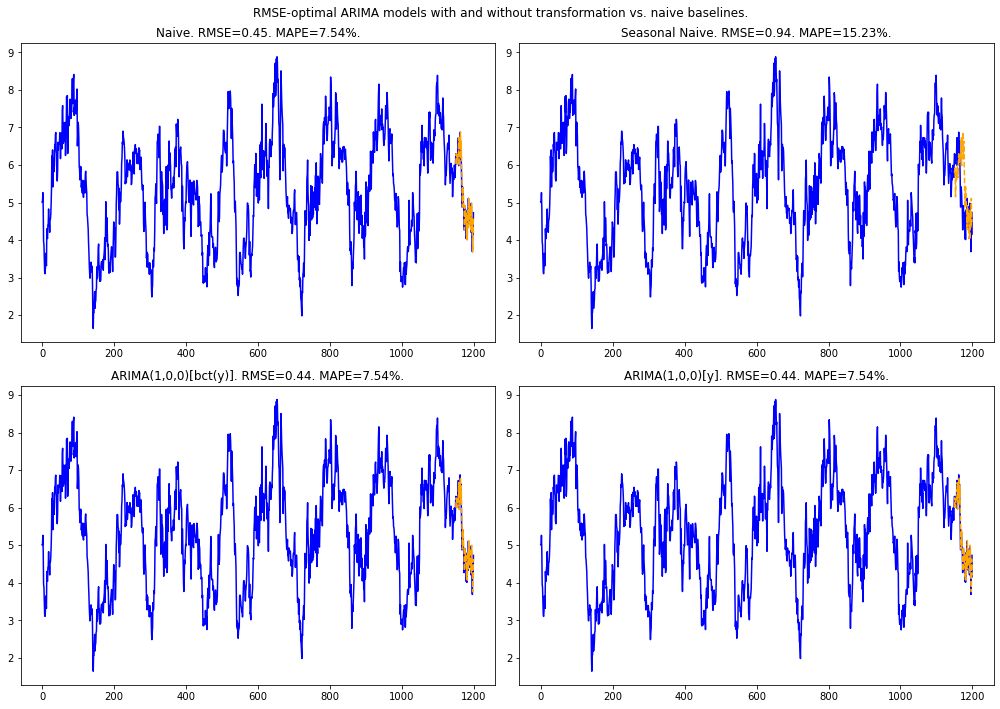

In [204]:
vis_comp(savefig=True, path='results_initialguess_arima', suptitle='ARIMA')

In [192]:
results

{'bc': {(1, 0, 0): (0.43937485580823094,
   array([6.00258507, 6.26159472, 6.24023256, 6.00306608, 6.23687997,
          6.19276422, 6.17756817, 6.27862618, 6.66987417, 5.95707771,
          6.46069286, 6.66411504, 6.41827569, 6.81294476, 6.13287556,
          6.58169256, 6.13312401, 5.66101834, 4.90172033, 4.91553401,
          5.41523589, 5.24733991, 4.95606296, 4.85668591, 4.31904885,
          4.90948211, 4.93445894, 4.64951046, 4.51869093, 4.76438846,
          4.09247709, 4.43916859, 4.07139448, 4.82323216, 4.65829832,
          4.37621496, 5.12303933, 4.64464459, 4.52244171, 4.45717099,
          4.91376222, 4.51804108, 4.51843977, 4.26253221, 4.99779988,
          4.60775571, 4.3744536 , 3.7623702 , 4.62314287, 4.19644363]),
   'Success')}}

In [11]:
#import data
df_wind = pd.read_csv(os.path.join(path, 'germany-wind-energy.csv'))
df_wind

,utc_timestamp,wind_generation_actual,wind_capacity,temperature
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908
...,...,...,...,...
1089,2019-12-26 00:00:00+00:00,132739.0,50424.125,2.790
1090,2019-12-27 00:00:00+00:00,146590.0,50427.000,1.327
1091,2019-12-28 00:00:00+00:00,159126.0,50427.292,-1.441
1092,2019-12-29 00:00:00+00:00,349839.0,50434.750,-1.314


In [14]:
#import data
df_all = pd.read_csv(os.path.join(path, 'all_energy_statistics.csv'))
df_all

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,NaN,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,NaN,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,NaN,additives_and_oxygenates
...,...,...,...,...,...,...,...
1189477,Viet Nam,Electricity - total wind production,2012,"Kilowatt-hours, million",92.0,1.0,wind_electricity
1189478,Viet Nam,Electricity - total wind production,2011,"Kilowatt-hours, million",87.0,NaN,wind_electricity
1189479,Viet Nam,Electricity - total wind production,2010,"Kilowatt-hours, million",50.0,NaN,wind_electricity
1189480,Viet Nam,Electricity - total wind production,2009,"Kilowatt-hours, million",10.0,NaN,wind_electricity
